In [1]:
# pip innstall -U tf-nightly
# version: 1.14.1
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
tf.__version__ 

'1.14.1-dev20190403'

In [3]:
import sys
import os

if sys.version_info.major >= 3:
    import pathlib
else:
    import pathlib2 as pathlib

# Add `models` to the python path.
models_path = os.path.join(os.getcwd(), "models")
sys.path.append(models_path)

## Convert to tflite model

In [7]:
graph_def_file = '...car_moblienet_v1_1.0_224.pb'
input_nodes = ['input']
output_nodes = ['class_id', 'prob']
converter = tf.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file, input_nodes, output_nodes)
tflite_model = converter.convert()

In [8]:
tflite_models_dir = pathlib.Path("./tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [9]:
tflite_model_file = tflite_models_dir/"car_mobilenet_v1_1.0_224.tflite"
tflite_model_file.write_bytes(tflite_model)

17845360

## DO quantize

In [11]:
# Quantize
tf.logging.set_verbosity(tf.logging.INFO)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/'car_mobilenet_v1_1.0_224_quant.tflite'
tflite_model_quant_file.write_bytes(tflite_quant_model)

7664328

In [12]:
!ls -lh {tflite_models_dir}

总用量 25M
-rw-rw-r-- 1 7.4M Apr  4 17:19 car_mobilenet_v1_1.0_224_quant.tflite
-rw-rw-r-- 1 18M Apr  4 17:07 car_mobilenet_v1_1.0_224.tflite


## Test model on data

In [15]:
from dataset_factory import get_cars_dataset_from_record, CAR_RECORD_INFO
val_ds = get_cars_dataset_from_record(
    False, data_dir='...tfrecord/',
    batch_size=1,
    val_prefix='validation')

Read validation data.


In [19]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
class_id_index = interpreter.get_output_details()[0]["index"]
prob_index = interpreter.get_output_details()[1]["index"]

In [18]:
interpreter.get_output_details()

[{'name': 'class_id',
  'index': 5,
  'shape': array([1], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0)},
 {'name': 'prob',
  'index': 15,
  'shape': array([  1, 196], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [20]:
tf.logging.set_verbosity(tf.logging.DEBUG)
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))

In [21]:
interpreter_quant.allocate_tensors()
input_index = interpreter_quant.get_input_details()[0]["index"]
class_id_index = interpreter_quant.get_output_details()[0]["index"]
prob_index = interpreter_quant.get_output_details()[0]["index"]

In [23]:
for img, label in val_ds.take(1):
    break

In [31]:
interpreter.set_tensor(input_index, img)
interpreter.invoke()
predictions = interpreter.get_tensor(class_id_index)

W0404 17:51:41.685300 139881372862208 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


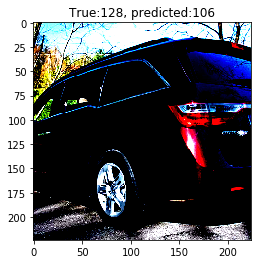

In [32]:
import matplotlib.pylab as plt
%matplotlib inline
plt.imshow(img[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(label[0].numpy()),
                              predict=str(predictions[0])))
plt.grid(False)

## Eval

In [44]:
import time
def eval_model(interpreter, ds):
    total_seen = 0
    num_correct = 0
    start_time = time.time()
    for img, label in ds:
        total_seen += 1
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        predictions = interpreter.get_tensor(class_id_index)
        if predictions == label.numpy():
            num_correct += 1

        if total_seen % 500 == 0:
            print("Accuracy after %i images: %f" %
              (total_seen, float(num_correct) / float(total_seen)))
    print('Tic tok:', time.time() - start_time)
    return float(num_correct) / float(total_seen)

In [45]:
print(eval_model(interpreter, val_ds))

Accuracy after 500 images: 0.776000
Accuracy after 1000 images: 0.793000
Accuracy after 1500 images: 0.804667
0.8003708281829419


In [46]:
print(eval_model(interpreter_quant, val_ds))

Accuracy after 500 images: 0.772000
Accuracy after 1000 images: 0.792000
Accuracy after 1500 images: 0.805333
0.8022249690976514


https://github.com/tensorflow/tensorflow/blob/v2.0.0-alpha0/tensorflow/lite/tutorials/post_training_quant.ipynb